## Load and Visualize the Dataset

Dataset Link: [Kaggle-Butterfly Image Classification dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)

### Load Images

In [1]:
IMG_SIZE = (128, 128)

In [2]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import numpy as np

pd.options.mode.chained_assignment = None

def load_img(img_path):
    img = Image.open(img_path)
    img = img.resize(IMG_SIZE)
    img_arr = np.array(img)
    return img_arr

ind_to_label = list()
label_to_ind = dict()

def load_ds(path, random_state=42):
    df = pd.read_csv(path + 'Training_set.csv')
    df = df.sample(frac=1, random_state=random_state)
    val_df = df[6000:]
    train_df = df[:6000]
    
    img_dir = path + 'train/'
    train_df['filepath'] = train_df['filename'].map(lambda x: img_dir + x)
    val_df['filepath'] = val_df['filename'].map(lambda x: img_dir + x)

    train_df['img'] = train_df['filepath'].map(load_img) / 255.
    val_df['img'] = val_df['filepath'].map(load_img) / 255.

    labels = set(train_df['label'])

    ind_to_label = list(labels)
    
    for i in range(0, len(ind_to_label)):
        label_to_ind[ind_to_label[i]] = i
    
    train_df['y'] = train_df['label'].map(lambda x: label_to_ind[x])
    val_df['y'] = val_df['label'].map(lambda x:label_to_ind[x])
    
    return train_df, val_df, labels

2025-04-11 07:32:11.676755: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744356731.873821      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744356731.928794      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df, val_df, labels = load_ds('/kaggle/input/butterfly-image-classification/')

In [4]:
train_df.head(2)

,filename,label,filepath,img,y
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...,"[[[0.9333333333333333, 0.9333333333333333, 0.9...",10
1703,Image_1704.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...,"[[[0.45098039215686275, 0.5294117647058824, 0....",0


### Visualize images

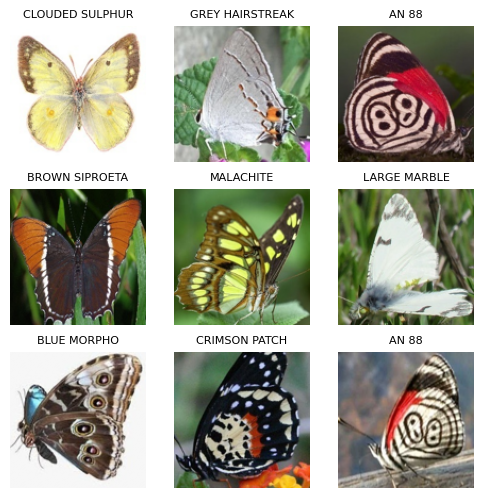

In [5]:
import matplotlib.pyplot as plt
import random

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(0, 9):
    img_ind = random.randint(0, len(train_df))
    data_pt = train_df.iloc[img_ind]
    ax[i//3][i%3].imshow(data_pt['img'])
    ax[i//3][i%3].set_title(data_pt['label'], fontsize=8)
    ax[i//3][i%3].axis('off')

## Model architecture

In [6]:
INPUT_SHAPE = IMG_SIZE + (3,)
INPUT_SHAPE

(128, 128, 3)

In [7]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    activation='tanh',
    kernel_size=3,
    padding='same',
    kernel_initializer='he_normal',
)

input = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = tf.keras.layers.Normalization()(input)
x = DefaultConv2D(filters=64)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = DefaultConv2D(filters=256)(x)
x = DefaultConv2D(filters=256)(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=200)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=100)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=100)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(units=100)(x)
x = tf.keras.layers.Dense(units=len(labels))(x)

model = tf.keras.Model(inputs=input, outputs=x)
model.summary()

I0000 00:00:1744356802.331617      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 128, 128, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │      13,107,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 75)                  │           7,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,263,762 (54.41 MB)

 Trainable params: 14,263,755 (54.41 MB)

 Non-trainable params: 7 (32.00 B)

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    optimizer='adam'
)

In [9]:
train_X = np.stack(train_df['img'].values)
train_Y = train_df['y'].values

val_X = np.stack(val_df['img'].values)
val_Y = val_df['y'].values

print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)

(6000, 128, 128, 3) (6000,)
(499, 128, 128, 3) (499,)


In [10]:
model.fit(
    x=train_X,
    y=train_Y,
    validation_data=(val_X, val_Y),
    epochs=100,
    batch_size=32
)

Epoch 1/100


I0000 00:00:1744356811.796681      95 service.cc:148] XLA service 0x7b855c0016c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744356811.797514      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744356812.201529      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/188 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.0183 - loss: 12.9396

I0000 00:00:1744356819.256088      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - accuracy: 0.0134 - loss: 13.1160 - val_accuracy: 0.0140 - val_loss: 15.8178
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0146 - loss: 15.4526 - val_accuracy: 0.0140 - val_loss: 16.2888
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0143 - loss: 15.3701 - val_accuracy: 0.0080 - val_loss: 16.4533
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0152 - loss: 15.9077 - val_accuracy: 0.0080 - val_loss: 16.5459
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0140 - loss: 15.9025 - val_accuracy: 0.0080 - val_loss: 16.5502
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0136 - loss: 16.3589 - val_accuracy: 0.0080 - val_loss: 16.6794
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0169 - loss: 16.1898 - val_accuracy: 0.0080 - val_loss: 16.6794
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.0141 - loss: 16.268